In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri


In [2]:
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/miniconda3/envs/scrnseq/lib/R/library")

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(clustree)
library(SingleCellExperiment)
library(CHETAH)
library(SingleR)
library(cowplot)
library(Matrix)

### Data Recall

In [5]:
adata = sc.read("/home/spuccio/homeserver2/SP018_Pelosi/Integration_APE_pos_APE_neg/Desc.h5ad")
adata2 = sc.read("/home/spuccio/homeserver2/SP018_Pelosi/Integration_APE_pos_APE_neg/No_Desc.h5ad")

In [6]:
adata.shape == adata2.shape

True

### Clustree

In [7]:
data_clus = adata2.obs[['desc_0.4','desc_0.6','desc_0.7','desc_0.8']]

In [8]:
data_clus.columns

Index(['desc_0.4', 'desc_0.6', 'desc_0.7', 'desc_0.8'], dtype='object')

In [9]:
data_clus.columns = ['desc_r4_clusters', 'desc_r6_clusters', 'desc_r7_clusters', 'desc_r8_clusters']

In [10]:
data_clus.to_csv("/home/spuccio/homeserver2/SP018_Pelosi/Temp/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/home/spuccio/homeserver2/SP018_Pelosi/Temp/temp.csv",index_col=0,header=0)

In [11]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command

old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

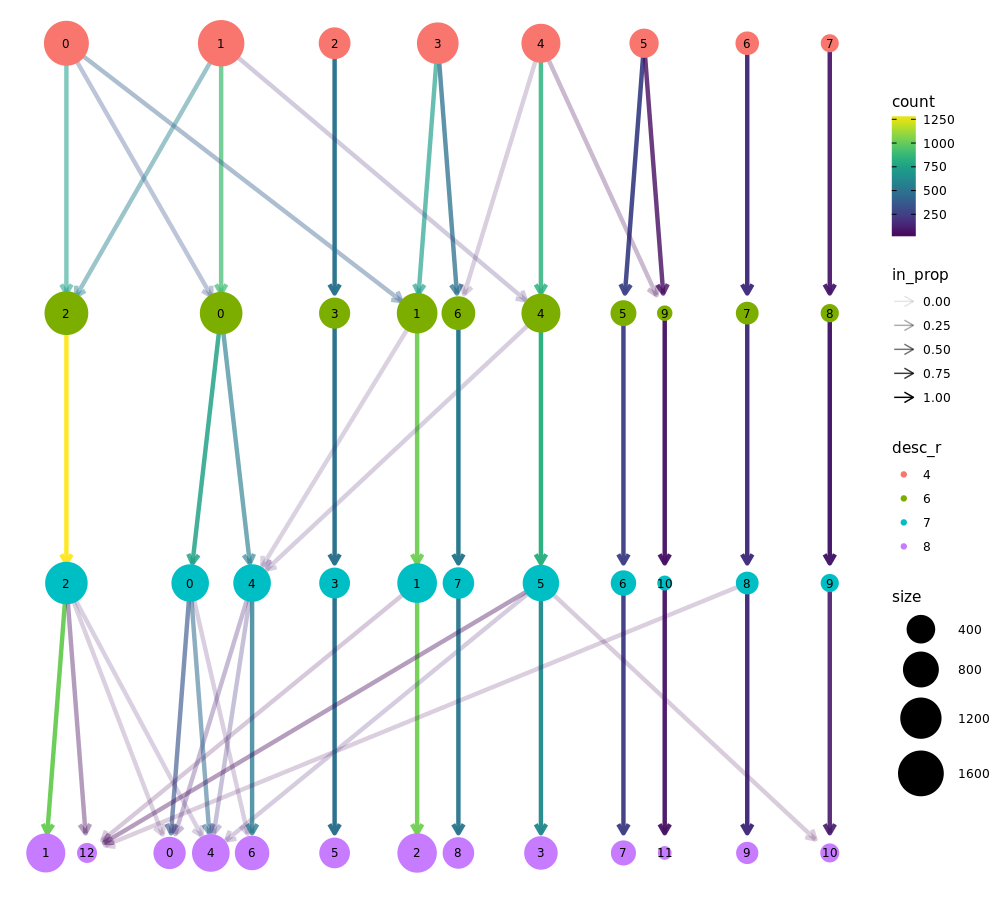

In [12]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="desc_r",suffix = "_clusters")

### Resolution 0.4

In [13]:
def run_vis(adata):
    if 'X_emb' in adata.obsm:
        sc.pp.neighbors(adata, use_rep='X_emb')
        sc.tl.umap(adata)
    else:
        sc.pp.pca(adata, svd_solver='arpack')
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)

In [14]:
adata2.obsm['X_emb'] = adata2.obsm['X_Embeded_z'+str(0.4)]
run_vis(adata2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


In [15]:
adata2.obs['dataset'] = adata2.obs['dataset'].astype(str)

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'dataset' as categorical


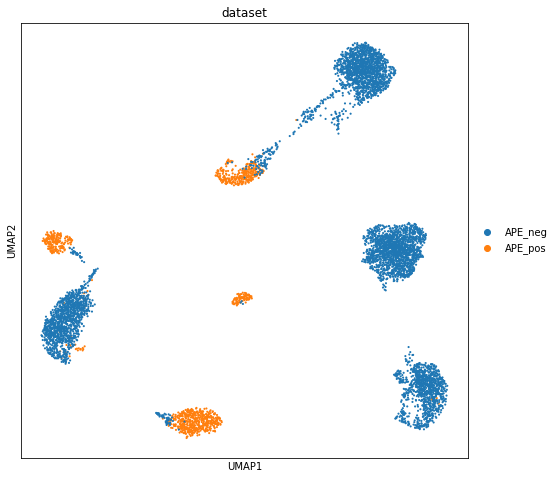

In [16]:
sc.pl.umap(adata2, color='dataset'); plt.show()

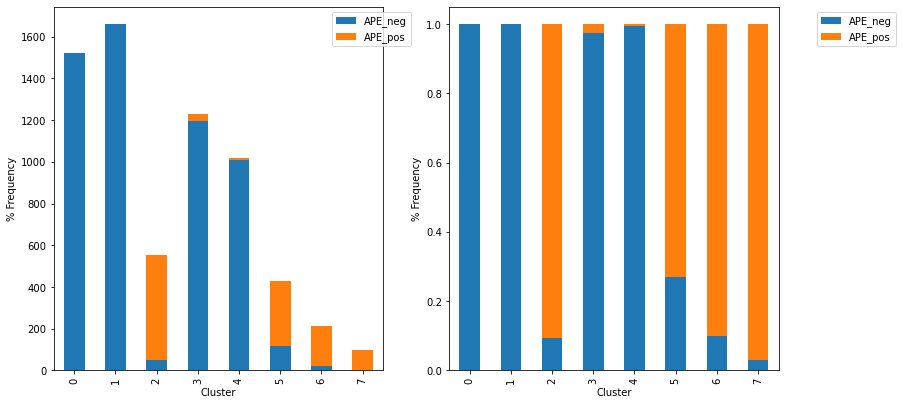

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(33/2.54, 17/2.54))
ax1 = adata2.obs.groupby("desc_0.4")["dataset"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))
ax2 = adata2.obs.groupby("desc_0.4")["dataset"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("% Frequency")
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.1, 1.0))

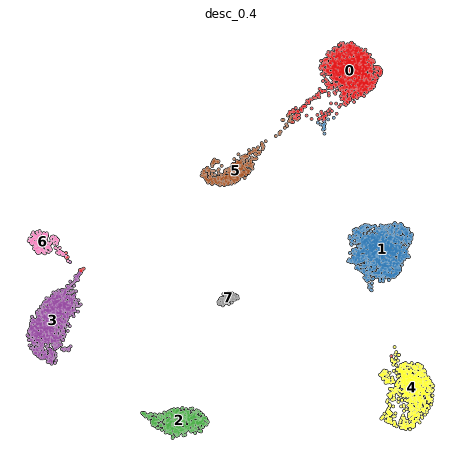

In [18]:
rcParams['figure.figsize'] = 8, 8
sc.pl.umap(adata2, color='desc_0.4', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.4', palette='Set1')

### Compute Markers Gene Resolution 0.4

In [19]:
adata2.var.index = adata2.var.index.astype(str)
adata2.raw.var.index = adata2.raw.var.index.astype(str)
adata2.raw.index = adata2.var.index

In [20]:
sc.tl.rank_genes_groups(adata2, 'desc_0.4', method='wilcoxon')
pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(25)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


,0,1,2,3,4,5,6,7
0,CRHBP,AVP,RGS10,EREG,CD99,SH3BGRL3,IL7R,SEC61B
1,AVP,HOPX,HLA-DPA1,LDHB,MZB1,FTL,KLRB1,PLAC8
2,MLLT3,SPINK2,CD74,PNN,ITM2C,S100A4,BTG1,CCDC50
3,EGFL7,NPDC1,C1orf54,HMGB1,DNTT,TYROBP,TNFAIP3,TCF4
4,MDK,FHL1,SNX3,HSP90AB1,NKG7,FTH1,LTB,IRF7
5,SPINK2,C1QTNF4,ID2,HSPA5,TSC22D1,S100A6,CD7,GZMB
6,BEX1,EGFL7,CLEC9A,PTMA,LTB,LST1,CTSW,SPCS1
7,LAPTM4B,KLF2,CPVL,PRSS57,SPINK2,EIF1,IL32,C12orf75
8,SOCS2,ITM2C,BATF3,YBX1,JCHAIN,S100A11,CDC14A,PPP1R14B
9,BAALC,CD99,HLA-B,SERPINB1,STMN1,CTSS,GATA3,UGCG


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:07)
Storing dendrogram info using `.uns["dendrogram_['desc_0.4']"]`
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_desc_0.4']`


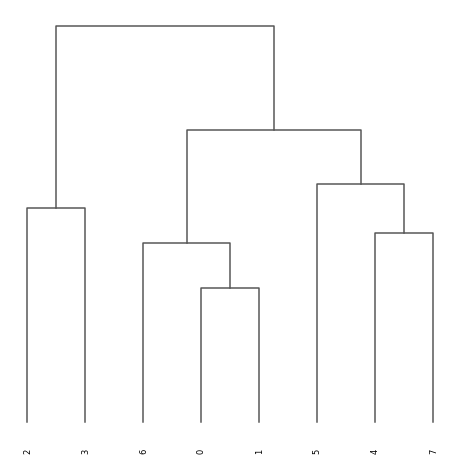

In [21]:
sc.tl.dendrogram(adata2, 'desc_0.4')
ax = sc.pl.dendrogram(adata2, 'desc_0.4')

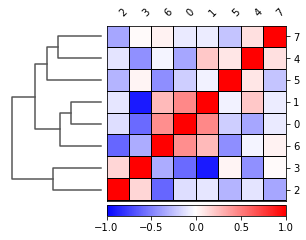

In [22]:
ax = sc.pl.correlation_matrix(adata2, 'desc_0.4', figsize=(5,3.5))

### Export Resolution 0.4

In [23]:
result = adata2.uns['rank_genes_groups']

In [24]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:3]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).to_csv("/home/spuccio/homeserver2/SP018_Pelosi/Integration_APE_pos_APE_neg/Integrated_res04_DEGS.csv",header=True,index=False)

### Analysis Resolution 0.6

In [25]:
adata2.obsm['X_emb'] = adata2.obsm['X_Embeded_z'+str(0.6)]
run_vis(adata2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


In [26]:
adata2.obs['dataset'] = adata2.obs['dataset'].astype(str)

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'dataset' as categorical


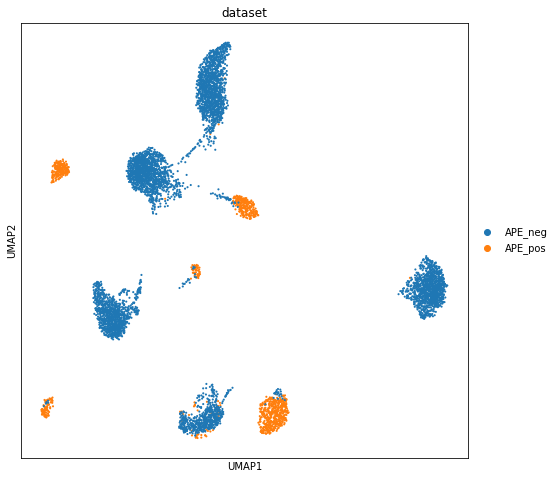

In [27]:
sc.pl.umap(adata2, color='dataset'); plt.show()

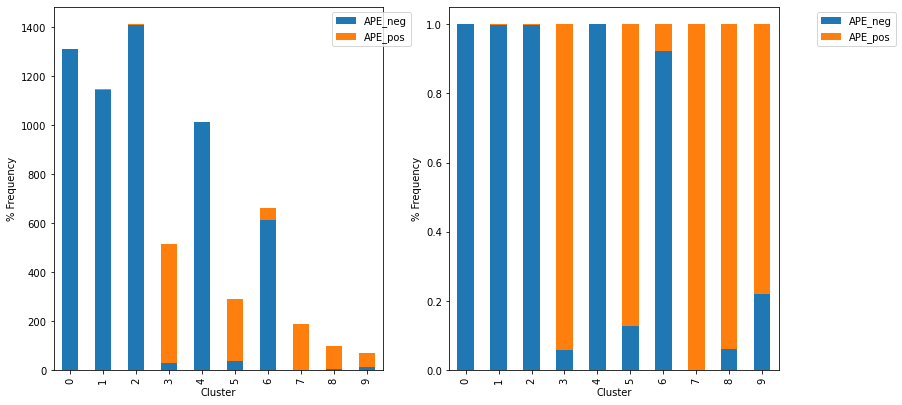

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(33/2.54, 17/2.54))
ax1 = adata2.obs.groupby("desc_0.6")["dataset"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))
ax2 = adata2.obs.groupby("desc_0.6")["dataset"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("% Frequency")
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.1, 1.0))

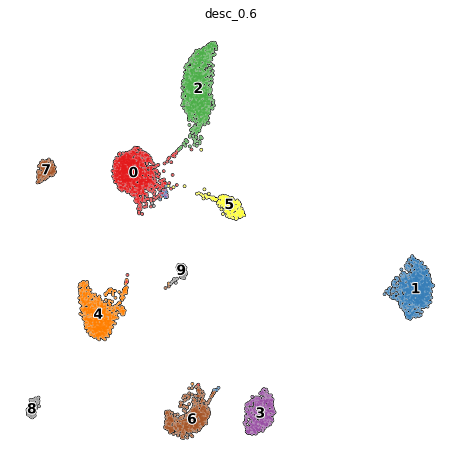

In [29]:
rcParams['figure.figsize'] = 8, 8
sc.pl.umap(adata2, color='desc_0.6', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.6', palette='Set1')


### Compute Markers Gene Resolution 0.6

In [30]:
sc.tl.rank_genes_groups(adata2, 'desc_0.6', method='wilcoxon')
pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(25)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


,0,1,2,3,4,5,6,7,8,9
0,SPINK2,SERPINB1,AVP,SNX3,CD99,TYROBP,STMN1,IL7R,SEC61B,FTL
1,C1QTNF4,EREG,CRHBP,RGS10,ITM2C,SH3BGRL3,TUBA1B,KLRB1,CCDC50,S100A9
2,HOPX,GATA2,MLLT3,HLA-DPA1,MZB1,ARL4C,TYMS,BTG1,PLAC8,S100A6
3,CD99,FCER1A,MDK,CD74,TSC22D1,FTL,DUT,TNFAIP3,TCF4,FCER1G
4,EGFL7,SOX4,KLF2,C1orf54,DNTT,LST1,HMGB1,LTB,IRF7,S100A11
5,NPDC1,CYTL1,HOPX,ID2,NKG7,FTH1,LDHB,CD7,IL3RA,TYROBP
6,ARMH1,MPP1,ID1,CPVL,SPINK2,S100A11,NASP,IL32,SPCS1,S100A8
7,SMIM24,CTNNBL1,BEX1,S100A10,LTB,ARPC3,PTMA,CTSW,GZMB,S100A4
8,AVP,PKIG,ID3,CLEC9A,HOPX,EIF1,RANBP1,GATA3,MZB1,TSPO
9,PRSS57,PDZD8,BST2,HLA-B,C1QTNF4,CEBPD,GAPDH,CDC14A,JCHAIN,FCN1


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['desc_0.6']"]`
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_desc_0.6']`


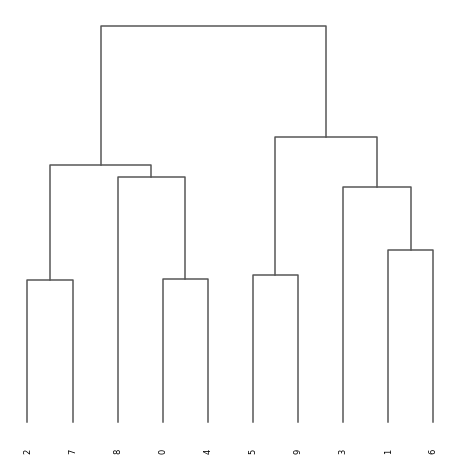

In [31]:
sc.tl.dendrogram(adata2, 'desc_0.6')
ax = sc.pl.dendrogram(adata2, 'desc_0.6')

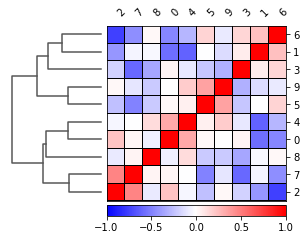

In [32]:
ax = sc.pl.correlation_matrix(adata2, 'desc_0.6', figsize=(5,3.5))

### Export Resolution 0.6

In [33]:
result = adata2.uns['rank_genes_groups']

In [34]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:3]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).to_csv("/home/spuccio/homeserver2/SP018_Pelosi/Integration_APE_pos_APE_neg/Integrated_res06_DEGS.csv",header=True,index=False)

### Resolution 0.8

In [35]:
adata2.obsm['X_emb'] = adata2.obsm['X_Embeded_z'+str(0.8)]
run_vis(adata2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


In [36]:
adata2.obs['dataset'] = adata2.obs['dataset'].astype(str)

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'dataset' as categorical


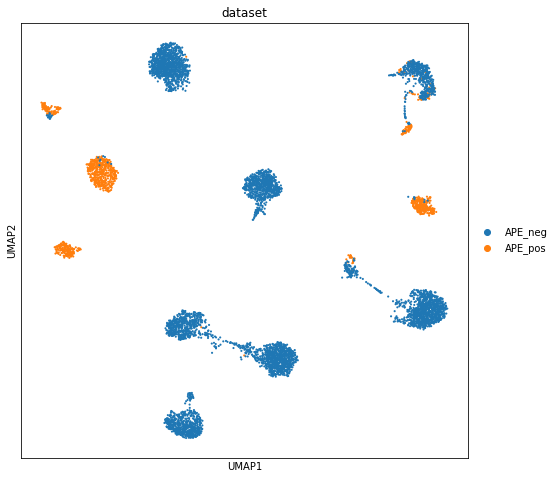

In [37]:
sc.pl.umap(adata2, color='dataset'); plt.show()

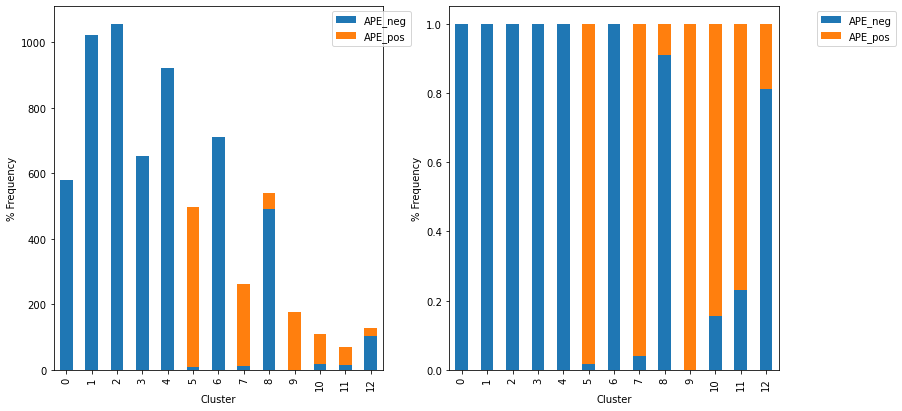

In [38]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(33/2.54, 17/2.54))
ax1 = adata2.obs.groupby("desc_0.8")["dataset"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))
ax2 = adata2.obs.groupby("desc_0.8")["dataset"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("% Frequency")
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.1, 1.0))

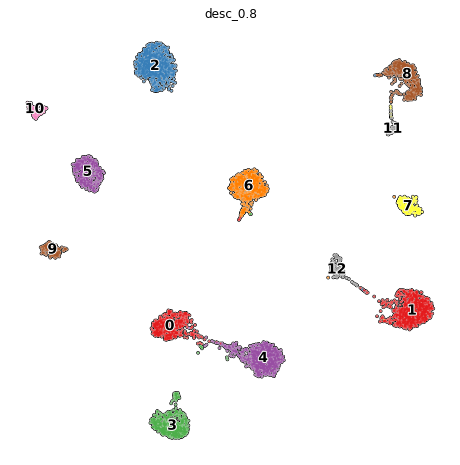

In [39]:
rcParams['figure.figsize'] = 8, 8
sc.pl.umap(adata2, color='desc_0.8', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.8', palette='Set1')

### Compute Markers Gene Resolution 0.8

In [40]:
sc.tl.rank_genes_groups(adata2, 'desc_0.8', method='wilcoxon')
pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(25)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,SPINK2,AVP,EREG,CD99,ITM2C,SNX3,CD69,TYROBP,STMN1,IL7R,CCDC50,S100A11,TREML1
1,HOPX,CRHBP,FCER1A,DNTT,CD99,C1orf54,CXCL8,GPR183,TYMS,BTG1,PLAC8,S100A9,PF4
2,C1QTNF4,MLLT3,GATA2,MZB1,NPDC1,RGS10,SPINK2,FCER1G,TUBA1B,KLRB1,TCF4,FTL,PPBP
3,EGFL7,MDK,SERPINB1,ITM2C,FHL1,CD74,C1QTNF4,ARL4C,DUT,TNFAIP3,SEC61B,S100A6,MYL9
4,AVP,KLF2,CYTL1,LTB,VIM,HLA-DPA1,EGFL7,LST1,HMGB1,LTB,IRF7,TYROBP,CALD1
5,ARMH1,BEX1,CTNNBL1,TSC22D1,ANXA1,HLA-B,NUCB2,FTH1,PCLAF,CD7,JCHAIN,S100A4,GP9
6,SMIM24,ID1,PKIG,NKG7,SPINK2,CPVL,NPDC1,CEBPD,NASP,CD69,SCT,FCER1G,F13A1
7,PRSS57,SOCS2,SOX4,HOPX,C1QTNF4,HLA-DPB1,HOPX,SH3BGRL3,TUBB,IL32,IL3RA,S100A8,SPX
8,CD99,BST2,MPP1,SPINK2,EGFL7,IRF8,PRSS57,IGSF6,GAPDH,CDC14A,SPCS1,TSPO,CMTM5
9,NUCB2,HOPX,PNN,ADA,HOPX,S100A10,NFKBIA,COTL1,RANBP1,GATA3,IRF8,CTSS,PF4V1


In [41]:
sc.tl.dendrogram(adata2, 'desc_0.8')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['desc_0.8']"]`


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_desc_0.8']`


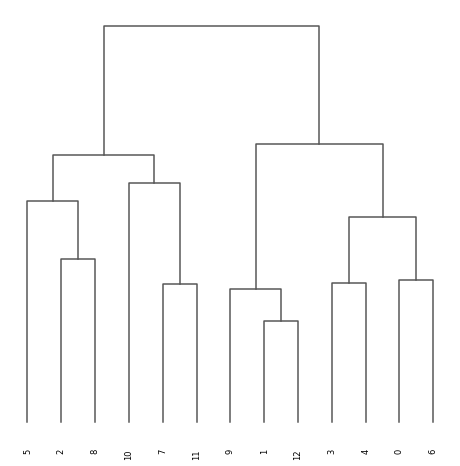

In [42]:
ax = sc.pl.dendrogram(adata2, 'desc_0.8')

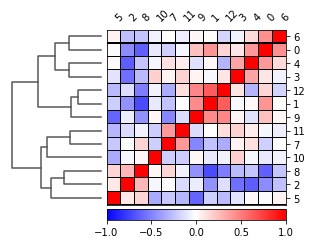

In [43]:
ax = sc.pl.correlation_matrix(adata2, 'desc_0.8', figsize=(5,3.5))

### Export Resolution 0.8

In [44]:
result = adata2.uns['rank_genes_groups']

In [45]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:3]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).to_csv("/home/spuccio/homeserver2/SP018_Pelosi/Integration_APE_pos_APE_neg/Integrated_res08_DEGS.csv",header=True,index=False)